In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance

import os

%load_ext autoreload
%autoreload 2
from data_preprocessing import initial_data_preprocessing

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
os.listdir("./../../data/")

['.DS_Store', 'raw_data', 'automatic_stations_catalog.xlsx']

# Exploratory Data Analysis and Data Preprocessing

## Initial Data Investigation

In [3]:
df_automatic_stations = pd.read_excel('./../../data/automatic_stations_catalog.xlsx')[[
                                                        'DC_NOME','SG_ESTADO','CD_SITUACAO',
                                                        'VL_LATITUDE','VL_LONGITUDE','VL_ALTITUDE',
                                                        'DT_INICIO_OPERACAO','CD_ESTACAO']]

df_automatic_stations = df_automatic_stations.query("CD_SITUACAO != 'Pane'")
df_automatic_stations

,DC_NOME,SG_ESTADO,CD_SITUACAO,VL_LATITUDE,VL_LONGITUDE,VL_ALTITUDE,DT_INICIO_OPERACAO,CD_ESTACAO
3,AGUA BOA,MT,Operante,-14.016389,-52.211667,440.00,2006-12-15,A908
4,AGUA CLARA,MS,Operante,-20.444444,-52.875833,323.63,2010-08-13,A756
5,AGUAS EMENDADAS,DF,Operante,-15.596491,-47.625801,1030.36,2008-10-02,A045
6,AGUAS VERMELHAS,MG,Operante,-15.751536,-41.457787,754.07,2007-09-08,A549
7,AIMORES,MG,Operante,-19.532778,-41.090833,287.74,2007-08-04,A534
...,...,...,...,...,...,...,...,...
566,REDENCAO,PA,Operante,-8.043333,-50.006944,199.00,2019-07-10,A254
567,VOTUPORANGA,SP,Operante,-20.403333,-49.966111,510.37,2006-12-03,A729
568,XANXERE,SC,Operante,-26.938666,-52.398090,878.74,2008-03-14,A858
569,ZE DOCA,MA,Operante,-3.269167,-45.651111,45.50,2019-09-17,A255


### Jeremoabo is our region of interest

In [4]:
df_automatic_stations.query("DC_NOME == 'JEREMOABO'")

,DC_NOME,SG_ESTADO,CD_SITUACAO,VL_LATITUDE,VL_LONGITUDE,VL_ALTITUDE,DT_INICIO_OPERACAO,CD_ESTACAO
458,JEREMOABO,BA,Operante,-10.080833,-38.345833,261.0,2015-08-12,A450


### Calculating closest stations to Jeremoabo

In [5]:
jeremoabo_lat = -10.080833
jeremoabo_long = -38.345833

distances_km = [distance((jeremoabo_lat,jeremoabo_long),(station[0],station[1])).km for station in 
                        zip(df_automatic_stations['VL_LATITUDE'].values,
                            df_automatic_stations['VL_LONGITUDE'].values)]
df_automatic_stations['DIST_JEREMOABE_KM'] = distances_km

In [6]:
df_chosen_stations = df_automatic_stations.sort_values('DIST_JEREMOABE_KM',ascending=True).query("DIST_JEREMOABE_KM < 102")
df_chosen_stations

,DC_NOME,SG_ESTADO,CD_SITUACAO,VL_LATITUDE,VL_LONGITUDE,VL_ALTITUDE,DT_INICIO_OPERACAO,CD_ESTACAO,DIST_JEREMOABE_KM
458,JEREMOABO,BA,Operante,-10.080833,-38.345833,261.00,2015-08-12,A450,0.000051
268,POCO VERDE,SE,Operante,-10.738056,-38.108333,367.01,2008-04-02,A419,77.207370
506,PIRANHAS,AL,Operante,-9.622222,-37.767222,187.00,2017-09-19,A371,81.247291
248,EUCLIDES DA CUNHA,BA,Operante,-10.537233,-38.996605,431.96,2008-03-30,A442,87.347165
482,NOSSA SENHORA DA GLORIA,SE,Operante,-10.207778,-37.431944,271.00,2017-03-23,A453,101.133057


Let us pick data from Jeremoabo (main target), Piranhas, Euclides da Cunha and Ribeira do Amparo.

In [7]:
northeast_stations = os.listdir('./../../data/raw_data')
# northeast_stations = [x.split('.')[0].replace('dados_','') for x in northeast_stations]
df_northeast_stations = pd.DataFrame(data=northeast_stations,columns=['STATION_FILE_NAME'])
df_northeast_stations['CD_ESTACAO'] = [x.split('.')[0].replace('dados_','').split('_H_')[0] for x in northeast_stations]
df_chosen_stations.merge(df_northeast_stations,on='CD_ESTACAO')

,DC_NOME,SG_ESTADO,CD_SITUACAO,VL_LATITUDE,VL_LONGITUDE,VL_ALTITUDE,DT_INICIO_OPERACAO,CD_ESTACAO,DIST_JEREMOABE_KM,STATION_FILE_NAME
0,JEREMOABO,BA,Operante,-10.080833,-38.345833,261.00,2015-08-12,A450,0.000051,dados_A450_H_2015-08-12_2022-04-10.csv
1,POCO VERDE,SE,Operante,-10.738056,-38.108333,367.01,2008-04-02,A419,77.207370,dados_A419_H_2012-01-01_2022-04-10.csv
2,PIRANHAS,AL,Operante,-9.622222,-37.767222,187.00,2017-09-19,A371,81.247291,dados_A371_H_2017-09-19_2022-04-10.csv
3,EUCLIDES DA CUNHA,BA,Operante,-10.537233,-38.996605,431.96,2008-03-30,A442,87.347165,dados_A442_H_2012-01-01_2022-04-10.csv
4,NOSSA SENHORA DA GLORIA,SE,Operante,-10.207778,-37.431944,271.00,2017-03-23,A453,101.133057,dados_A453_H_2017-03-23_2022-04-10.csv


In [8]:
df_chosen_stations.merge(df_northeast_stations,on='CD_ESTACAO').sort_values('DT_INICIO_OPERACAO',ascending=False)['DT_INICIO_OPERACAO'].tolist()[0]


Timestamp('2017-09-19 00:00:00')

We will extract data starting at 2017-09-19 to align all available data from all stations.

## Data preprocessing and EDA of Stations Measures

### Jeremoabo

In [5]:
df = pd.read_csv( './../../data/raw_data/dados_A450_H_2015-08-12_2022-04-10.csv',header=9,sep=';')
df = initial_data_preprocessing(df)

Dataset initial size:  (58416, 23)
Dataset final size:  (37425, 23)


In [6]:
df.dropna()

DATE_MEASUREMENT                               37425
HOUR_MEASUREMENT                               37425
TOTAL_PRECIPITATION_mm                         36427
ATM_PRESSURE_mB                                37425
ATM_PRESSURE_SEA_LEVEL_mB                      36548
MAX_ATM_PRESSURE_PREV_HOUR_mB                  37423
MIN_ATM_PRESSURE_PREV_HOUR_mB                  37423
GLOBAL_RADIATION_Kjm2                          37425
AIR_TEMPERATURE_DRY_BULB_Celsius               37425
DEW_POINT_TEMPERATURE_Celsius                  35975
MAX_TEMPERATURE_PREV_HOUR_Celsius              37423
MIN_TEMPERATURE_PREV_HOUR_Celsius              37423
DEW_POINT_MAX_TEMPERATURE_PREV_HOUR_Celsius    35872
DEW_POINT_MIN_TEMPERATURE_PREV_HOUR_Celsius    35872
MAX_RELATIVE_HUMIDITY_PREV_HOUR_percentage     35891
MIN_RELATIVE_HUMIDITY_PREV_HOUR_percentage     35891
RELATIVE_HUMIDITY_percentage                   35975
WIND_DIRECTION_degrees                         37406
WIND_MAX_GUNS_ms                              

In [33]:
# df.isna().sum()

df[['WIND_SPEED_ms','WIND_SPEED_120m_ms']].agg([np.mean,np.median,np.std]) #pivotar essa tabela para achatar esse dataframe, transformar tudo em uma linha so com o nome da estacao.

,WIND_SPEED_ms,WIND_SPEED_120m_ms
mean,2.569705,4.009709
median,2.500000,3.900943
std,1.348272,2.103812


In [53]:
df.isna().sum().sum() # juntar isso com o de cima. valor absoluto de missing


10990

In [48]:
df.isna().sum().sum() / (df.shape[0] * (df.shape[1]- 4)) # juntar isso com o de cima. percentual de missing

0.015455472348205183

In [49]:
df.shape

(37425, 23)

In [52]:
df.isna().sum()

DATE_MEASUREMENT                                  0
HOUR_MEASUREMENT                                  0
TOTAL_PRECIPITATION_mm                          998
ATM_PRESSURE_mB                                   0
ATM_PRESSURE_SEA_LEVEL_mB                       877
MAX_ATM_PRESSURE_PREV_HOUR_mB                     2
MIN_ATM_PRESSURE_PREV_HOUR_mB                     2
GLOBAL_RADIATION_Kjm2                             0
AIR_TEMPERATURE_DRY_BULB_Celsius                  0
DEW_POINT_TEMPERATURE_Celsius                  1450
MAX_TEMPERATURE_PREV_HOUR_Celsius                 2
MIN_TEMPERATURE_PREV_HOUR_Celsius                 2
DEW_POINT_MAX_TEMPERATURE_PREV_HOUR_Celsius    1553
DEW_POINT_MIN_TEMPERATURE_PREV_HOUR_Celsius    1553
MAX_RELATIVE_HUMIDITY_PREV_HOUR_percentage     1534
MIN_RELATIVE_HUMIDITY_PREV_HOUR_percentage     1534
RELATIVE_HUMIDITY_percentage                   1450
WIND_DIRECTION_degrees                           19
WIND_MAX_GUNS_ms                                  8
WIND_SPEED_m

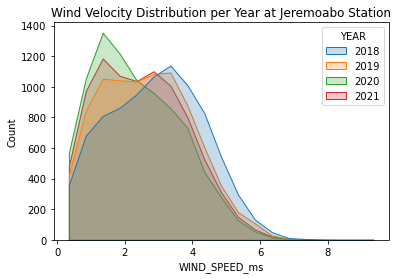

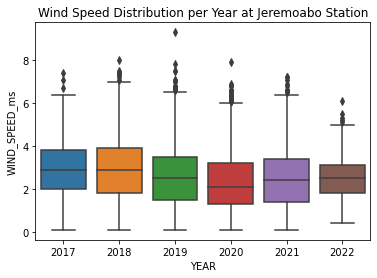

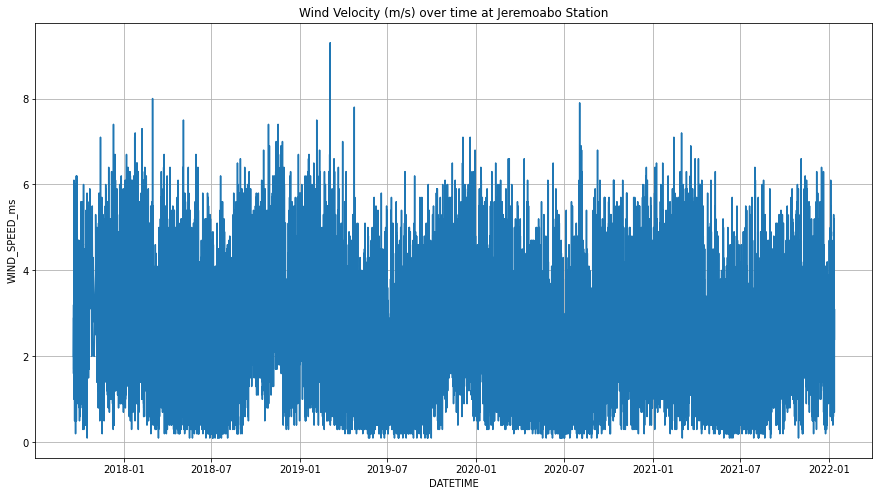

In [12]:
station_name = 'Jeremoabo'

sns.histplot(data=df.query("YEAR not in ('2017','2022')"),x='WIND_SPEED_ms',binwidth=0.5,hue='YEAR', element="poly")
plt.title(f"Wind Velocity Distribution per Year at {station_name} Station")
plt.show()

sns.boxplot(data=df,x='YEAR',y='WIND_SPEED_ms')
plt.title(f"Wind Speed Distribution per Year at {station_name} Station")
plt.show()

fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=df,y='WIND_SPEED_ms',x=df['DATETIME'])
plt.title(f"Wind Velocity (m/s) over time at {station_name} Station")
plt.grid(True)
plt.show()

### Piranhas

In [15]:
df = pd.read_csv( './../../data/raw_data/dados_A371_H_2017-09-19_2022-04-10.csv',header=9,sep=';')
df = initial_data_preprocessing(df)


Dataset initial size:  (39960, 23)
Dataset final size:  (32692, 23)


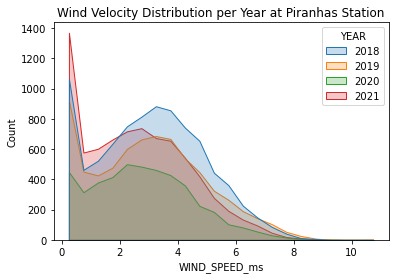

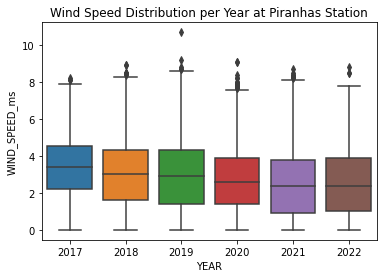

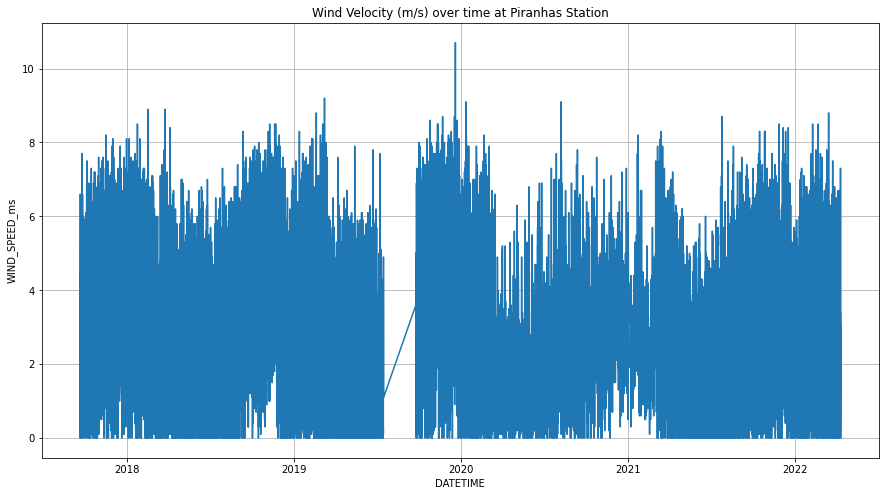

In [16]:
station_name = 'Piranhas'

sns.histplot(data=df.query("YEAR not in ('2017','2022')"),x='WIND_SPEED_ms',binwidth=0.5,hue='YEAR', element="poly")
plt.title(f"Wind Velocity Distribution per Year at {station_name} Station")
plt.show()

sns.boxplot(data=df,x='YEAR',y='WIND_SPEED_ms')
plt.title(f"Wind Speed Distribution per Year at {station_name} Station")
plt.show()

fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=df,y='WIND_SPEED_ms',x=df['DATETIME'])
plt.title(f"Wind Velocity (m/s) over time at {station_name} Station")
plt.grid(True)
plt.show()

### Euclides da Cunha

In [17]:
df = pd.read_csv( './../../data/raw_data/dados_A442_H_2012-01-01_2022-04-10.csv',header=9,sep=';')
df=initial_data_preprocessing(df)

Dataset initial size:  (90072, 23)
Dataset final size:  (33688, 23)


In [20]:
df.head()

,DATE_MEASUREMENT,HOUR_MEASUREMENT,TOTAL_PRECIPITATION_mm,ATM_PRESSURE_mB,ATM_PRESSURE_SEA_LEVEL_mB,MAX_ATM_PRESSURE_PREV_HOUR_mB,MIN_ATM_PRESSURE_PREV_HOUR_mB,GLOBAL_RADIATION_Kjm2,AIR_TEMPERATURE_DRY_BULB_Celsius,DEW_POINT_TEMPERATURE_Celsius,MAX_TEMPERATURE_PREV_HOUR_Celsius,MIN_TEMPERATURE_PREV_HOUR_Celsius,DEW_POINT_MAX_TEMPERATURE_PREV_HOUR_Celsius,DEW_POINT_MIN_TEMPERATURE_PREV_HOUR_Celsius,MAX_RELATIVE_HUMIDITY_PREV_HOUR_percentage,MIN_RELATIVE_HUMIDITY_PREV_HOUR_percentage,RELATIVE_HUMIDITY_percentage,WIND_DIRECTION_degrees,WIND_MAX_GUNS_ms,WIND_SPEED_ms,YEAR,DATETIME,WIND_SPEED_120m_ms
0,2017-09-19,0,0.0,970.5,NaN,970.5,969.9,-3.495,19.0,17.5,19.5,18.7,17.5,17.1,91.0,88.0,91.0,123.0,4.8,1.7,2017,2017-09-19 00:00:00,2.652641
1,2017-09-19,1,0.0,970.6,1021.024988,970.8,970.5,-2.352,19.4,17.7,19.5,19.0,18.0,17.6,91.0,90.0,90.0,150.0,5.0,3.0,2017,2017-09-19 01:00:00,4.681131
2,2017-09-19,2,0.0,970.5,1020.972873,970.7,970.5,-1.365,19.1,17.5,19.4,19.1,17.7,17.4,90.0,89.0,90.0,134.0,5.2,2.6,2017,2017-09-19 02:00:00,4.056981
3,2017-09-19,3,0.0,969.9,1020.412572,970.5,969.9,-1.178,18.7,17.2,19.2,18.7,17.5,17.1,91.0,90.0,91.0,145.0,7.2,3.2,2017,2017-09-19 03:00:00,4.993207
4,2017-09-19,4,0.0,969.2,1019.676116,969.9,969.2,-0.733,18.7,17.4,18.8,18.6,17.4,17.1,92.0,91.0,92.0,146.0,5.4,2.6,2017,2017-09-19 04:00:00,4.056981


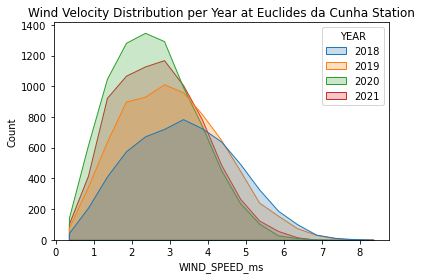

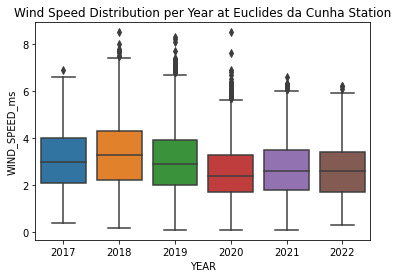

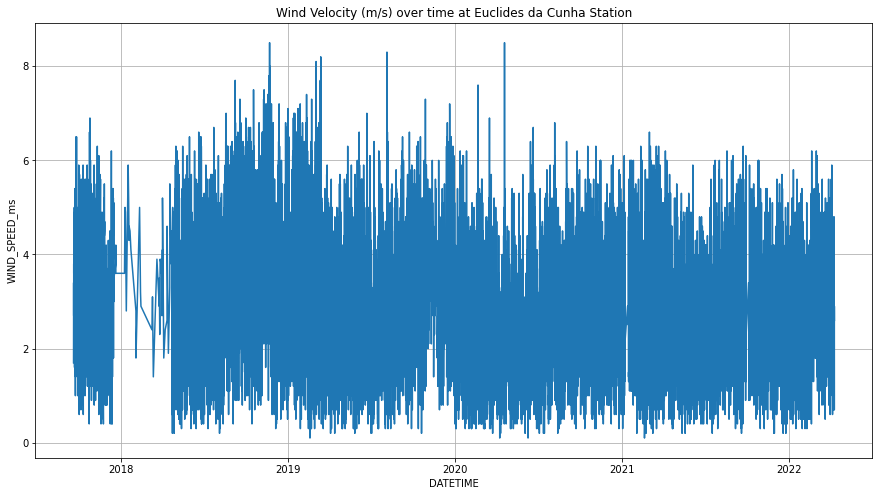

In [18]:
station_name = 'Euclides da Cunha'

sns.histplot(data=df.query("YEAR not in ('2017','2022')"),x='WIND_SPEED_ms',binwidth=0.5,hue='YEAR', element="poly")
plt.title(f"Wind Velocity Distribution per Year at {station_name} Station")
plt.show()

sns.boxplot(data=df,x='YEAR',y='WIND_SPEED_ms')
plt.title(f"Wind Speed Distribution per Year at {station_name} Station")
plt.show()

fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=df,y='WIND_SPEED_ms',x=df['DATETIME'])
plt.title(f"Wind Velocity (m/s) over time at {station_name} Station")
plt.grid(True)
plt.show()

# First Conclusions

The wind speed of the chosen areas are too low. We will have to analyse other areas.

In [19]:
# df_poco_verde = pd.read_csv( './../../data/raw_data/dados_A419_H_2012-01-01_2022-04-10.csv',header=9,sep=';')
# df_piranhas = pd.read_csv( './../../data/raw_data/dados_A371_H_2017-09-19_2022-04-10.csv',header=9,sep=';')
# df_euclides = pd.read_csv( './../../data/raw_data/dados_A442_H_2012-01-01_2022-04-10.csv',header=9,sep=';')
# df_nss_gloria = pd.read_csv( './../../data/raw_data/dados_A453_H_2017-03-23_2022-04-10.csv',header=9,sep=';')